In [30]:
import tensorflow as tf

## 1. Create Model

initialize and update weights manually

In [31]:
class MNIST:
    '''typical Neural Network structure'''
    def __init__(self, n_input, n_output): 
        '''define all tf variables, so that they can be trained
        '''
        # variables: weights and biases
        self.weights, self.biases = self.init_weights(n_input, n_output)

    @staticmethod
    def init_var(shape, name=None):
        return tf.Variable(tf.random.normal(shape, stddev=0.01, dtype='float64'), name=name)
    
    def init_weights(self, n_input, n_output):
        '''return tuple: (weights, biases)'''
        num1, num2 = 256, 128
        weights = {
            'hidden1': self.init_var([n_input, num1], name='W1'),
            'hidden2': self.init_var([num1, num2], name='W2'),
            'output':  self.init_var([num2, n_output], name='W3')
        }
        biases = {
            'hidden1': self.init_var([num1], name='b1'),
            'hidden2': self.init_var([num2], name='b2'),
            'output':  self.init_var([n_output], name='b3')
        }        
        return weights, biases
    
    def update_weights(self, tape, loss, learning_rate=0.05):
        '''update weights with GDA'''
        # collecting variables
        var = []
        var.extend(self.weights.values())
        var.extend(self.biases.values())
        
        # calculating gradient
        grads = tape.gradient(loss, var)
        
        # w = w - lr * w_grad
        for v, g in zip(var, grads):
            v.assign_sub(learning_rate * g)
        
    def build_model(self, inputs):
        ''' single hidden layer'''
        # hidden layer 1
        hidden_1 = tf.add(tf.matmul(inputs, self.weights['hidden1']), self.biases['hidden1'])
        hidden_1 = tf.nn.relu(hidden_1)
        # hidden layer 2
        hidden_2 = tf.add(tf.matmul(hidden_1, self.weights['hidden2']), self.biases['hidden2'])
        hidden_2 = tf.nn.relu(hidden_2)
        # output layer
        return tf.nn.softmax(tf.add(tf.matmul(hidden_2, self.weights['output']), self.biases['output']))    


    def build_loss(self, prediction, labels):
        '''cross entropy by default'''
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
   
    def build_accuracy(self, prediction, labels):
        '''to be implemented'''
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 2. Train Model

In [65]:
# load data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# batch dataset
x_train = x_train / 255.0
x_test = x_test / 255.0
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)

# network model
m = MNIST(28*28, 10)

# training
for epoch in range(5):
    # train all images batch by batch in a single epoch
    for step, (x, y) in enumerate(train_ds):
        # forward propagation
        with tf.GradientTape() as tape:
            x = tf.reshape(x, [-1, 28*28])
            predictions = m.build_model(x)            
            labels = tf.one_hot(y, depth=10)
            loss = m.build_loss(predictions, labels)
 
        # update weights
        m.update_weights(tape, loss, learning_rate=0.5)
 
        # display
        if step % 200 == 0:
            accuracy = m.build_accuracy(predictions, labels).numpy()
            print(f"Epoch {epoch:>6d}, Step {step:>8d}: loss = {loss.numpy():<8.4f} training accuracy = {accuracy:<5.4%}")

Epoch      0, Step        0: loss = 2.3027   training accuracy = 5.4688%
Epoch      0, Step      200: loss = 2.3022   training accuracy = 10.1562%
Epoch      0, Step      400: loss = 2.2960   training accuracy = 24.2188%
Epoch      1, Step        0: loss = 2.1732   training accuracy = 28.9062%
Epoch      1, Step      200: loss = 1.7155   training accuracy = 77.3438%
Epoch      1, Step      400: loss = 1.7447   training accuracy = 71.0938%
Epoch      2, Step        0: loss = 1.7302   training accuracy = 72.6562%
Epoch      2, Step      200: loss = 1.7092   training accuracy = 74.2188%
Epoch      2, Step      400: loss = 1.7329   training accuracy = 74.2188%
Epoch      3, Step        0: loss = 1.6652   training accuracy = 80.4688%
Epoch      3, Step      200: loss = 1.6405   training accuracy = 83.5938%
Epoch      3, Step      400: loss = 1.6446   training accuracy = 80.4688%
Epoch      4, Step        0: loss = 1.6072   training accuracy = 85.1562%
Epoch      4, Step      200: loss = 1.6

## 3. Test Model and Evaluation

In [66]:
# testing
x = tf.reshape(x_test, [-1, 28*28])
predictions = m.build_model(x)
labels = tf.one_hot(y_test, depth=10)
accuracy = m.build_accuracy(predictions, labels).numpy()
print(accuracy)

0.9082


0.92


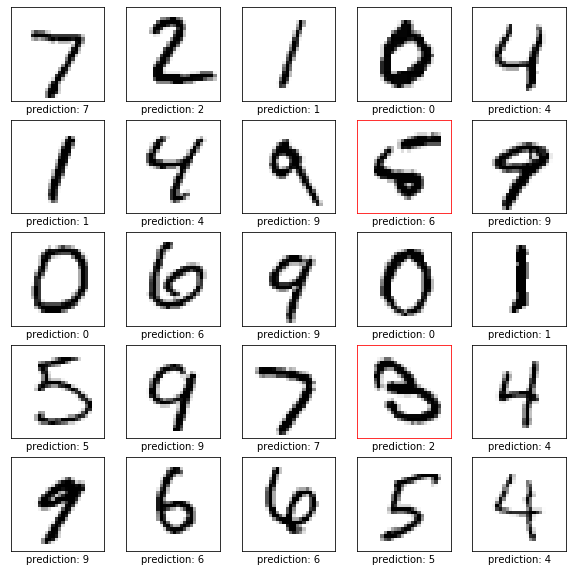

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

# evaluation
def evaluate(x, y):
    # reshape
    x = tf.reshape(x, [-1, 28*28])
    y = tf.one_hot(y, depth=10)    
    # predict
    y_ = m.build_model(x)
    accuracy = m.build_accuracy(y_, y).numpy()
    label = tf.argmax(y_, 1).numpy()
    return accuracy, label

num = 5
acc, predicted_y = evaluate(x_test[:num**2], y_test[:num**2])
print(acc)

# plots
plt.figure(figsize=(10,10))
for i in range(num**2):
    plt.subplot(num, num,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(f'prediction: {predicted_y[i]}')
    
    # mark error prediction with red border
    if y_test[i] != predicted_y[i]:
        ax = plt.gca()
        for name, border in ax.spines.items():
            border.set_color('red')
plt.show()